In [1]:
import numpy as np
import pandas as pd
import sys
import random

sys.path.insert(0, '..')

from unpast.run_unpast import unpast
from unpast.utils.method import prepare_input_matrix
from unpast.utils.consensus import make_consensus_biclusters

from unpast.utils.eval import calculate_perfromance
from unpast.utils.figs import draw_heatmap2

import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

#### Read and preprocess 3kPBMC data
* same preprocessing as in scanpy tutorial (https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering-2017.html)
* but retain more genes, and no regressing out mito counts

In [2]:
import scanpy as sc

In [3]:
!mkdir -p ../data/3kPBMC/
!curl https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -o ../data/3kPBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd ../data/3kPBMC/; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7443k  100 7443k    0     0  10.0M      0 --:--:-- --:--:-- --:--:-- 10.0M


In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.22.3 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.13.2 python-igraph==0.11.6 pynndescent==0.5.13


In [5]:
adata = sc.read_10x_mtx(
    "../data/3kPBMC/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata

... writing an h5ad cache file to speedup reading next time


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [6]:
# remove cells with < 200 genes expressed 
sc.pp.filter_cells(adata, min_genes=200)
# remove genes expressed in < 3 cells
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 19024 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [7]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
# Remove cells that have too many mitochondrial genes expressed or too many total counts
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [8]:
# normalize to 10K reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)
# log-transform
sc.pp.log1p(adata)

# no regression:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
#sc.pp.regress_out(adata, ["total_counts","pct_counts_mt"]) # 

# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [9]:
exprs = adata.to_df().T
exprs_file = "../data/3kPBMC/pbmc3k_13714Kgenes_norm_noregr.exprs.tsv.gz"
exprs.to_csv(exprs_file,sep ="\t")
exprs

,AAACATACAACCAC-1,AAACATTGAGCTAC-1,AAACATTGATCAGC-1,AAACCGTGCTTCCG-1,AAACCGTGTATGCG-1,AAACGCACTGGTAC-1,AAACGCTGACCAGT-1,AAACGCTGGTTCTT-1,AAACGCTGTAGCCA-1,AAACGCTGTTTCTG-1,...,TTTCAGTGTCACGA-1,TTTCAGTGTCTATC-1,TTTCAGTGTGCAGT-1,TTTCCAGAGGTGAG-1,TTTCGAACACCTGA-1,TTTCGAACTCTCAT-1,TTTCTACTGAGGCA-1,TTTCTACTTCCTCG-1,TTTGCATGAGAGGC-1,TTTGCATGCCTCAC-1
AL627309.1,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,...,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123,-0.058123
AP006222.2,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,...,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576,-0.033576
RP11-206L10.2,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,...,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668,-0.041668
RP11-206L10.9,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,...,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646,-0.033646
LINC00115,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,...,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240,-0.082240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC145212.1,-0.073893,-0.073893,-0.073893,-0.073893,-0.073893,-0.073893,-0.073893,-0.073893,-0.073893,-0.073893,...,-0.073893,-0.073893,-0.073893,-0.073893,-0.073893,-0.073893,-0.073893,-0.073893,-0.073893,-0.073893
AL592183.1,-0.360356,1.553802,-0.360356,-0.360356,-0.360356,-0.360356,-0.360356,-0.360356,-0.360356,-0.360356,...,-0.360356,-0.360356,-0.360356,-0.360356,-0.360356,-0.360356,-0.360356,-0.360356,-0.360356,-0.360356
AL354822.1,-0.052402,-0.052402,-0.052402,-0.052402,-0.052402,-0.052402,-0.052402,-0.052402,-0.052402,-0.052402,...,-0.052402,-0.052402,-0.052402,-0.052402,-0.052402,-0.052402,-0.052402,-0.052402,10.000000,-0.052402
PNRC2-1,-0.203856,-0.203856,-0.203856,-0.203856,-0.203856,-0.203856,-0.203856,-0.203856,-0.203856,-0.203856,...,-0.203856,-0.203856,-0.203856,-0.203856,-0.203856,-0.203856,-0.203856,-0.203856,-0.203856,-0.203856


In [16]:
annot = sc.datasets.pbmc3k_processed().obs.loc[:,["louvain"]]
annot["cell types"] = annot["louvain"].apply(lambda x: x.replace(" cells",""))
annot_file = "../data/3kPBMC/pbmc3k_13714Kgenes.annot.tsv.gz"
annot.to_csv(annot_file,sep ="\t") 
annot.head(3)

,louvain,cell types
index,,
AAACATACAACCAC-1,CD4 T cells,CD4 T
AAACATTGAGCTAC-1,B cells,B
AAACATTGATCAGC-1,CD4 T cells,CD4 T


# Biclustering analysis

In [11]:
n_runs = 5
analysis_seed = 0
random.seed(analysis_seed)
seeds = []
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

generate  5  seeds [885440, 403958, 794772, 933488, 441001]


In [12]:
basename = 'pbmc3k_13714Kgenes_norm_noregr'
out_dir = "../unpast_results/3kPBMC/"

In [13]:
sele_biomarkers = ["S100A8","FCRER1A","FCGR3A", "GNLY", "CD8A","CD8B", "CD14","CD74","MS4A7","KLRB1","LYZ"]

In [16]:
biclusters = []
for seed in seeds:
    results = unpast(exprs_file, basename,
                     out_dir=out_dir,
                     #ds=0,
                     save= True, 
                     seed = seed,
                     verbose = False
                 )    
    # make bicluster ids unique: 'seed=<seed>_<bicluster id>'
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values ]
    biclusters.append(results)
    print("seed = %s\tn_biclusters: %s"%(seed, results.shape[0]))


seed = 885440	n_biclusters: 894
seed = 403958	n_biclusters: 979
seed = 794772	n_biclusters: 927
seed = 933488	n_biclusters: 929
seed = 441001	n_biclusters: 980


In [17]:
# filter and z-score transform input matrix, limit z-scores to [-3,3]
exprs_z = prepare_input_matrix(pd.read_csv(exprs_file,sep="\t",index_col = 0),
                               min_n_samples=5,
                               ceiling=3)
consensus_biclusters= make_consensus_biclusters(biclusters, 
                                                exprs_z, 
                                                seed = analysis_seed,
                                                verbose = True,
                                                plot = False
                                                )


1248 s for similarity matrix
	Running Louvain ...
		modularity: newman
	curve type: increasing
	Louvain runtime: modules detected in 45.83 s.
	modules: 1185, not clustered features 1187 
		similarity cutoff: 0.53 modularity: 0.999
keep genes included in at least 2 merged biclusters
all consensus biclusters: 2424
detected 2+ times:1038
500 s for making consensus biclusters from consensus gene sets


In [18]:
from unpast.utils.io import write_bic_table, read_bic_table
bic_fname =  out_dir+basename+".seed="+str(analysis_seed)+".kmeans.consensus.biclsuters.tsv"
write_bic_table(consensus_biclusters,bic_fname)


In [19]:
### if pre-computed consensus biclustres avaiable
from unpast.utils.io import read_bic_table
bic_fname =  out_dir+basename+".seed="+str(analysis_seed)+".kmeans.consensus.biclsuters.tsv"
consensus_biclusters= read_bic_table(bic_fname)
exprs_file = "../data/3kPBMC/pbmc3k_13714Kgenes_norm_noregr.exprs.tsv.gz"
# filter and z-score transform input matrix, limit z-scores to [-3,3]
exprs_z = prepare_input_matrix(pd.read_csv(exprs_file,sep="\t",index_col = 0),
                               min_n_samples=5,
                               ceiling=3)
consensus_biclusters.shape[0]

1038

In [20]:
annot_file = "../data/3kPBMC/pbmc3k_13714Kgenes.annot.tsv.gz"
annot = pd.read_csv(annot_file, sep="\t",index_col=0)
annot.head(3)

,louvain,cell types
index,,
AAACATACAACCAC-1,CD4 T cells,CD4 T
AAACATTGAGCTAC-1,B cells,B
AAACATTGATCAGC-1,CD4 T cells,CD4 T


In [21]:
cell_types = [ "CD4 T", "B", "FCGR3A+ Monocytes","NK","CD8 T","CD14+ Monocytes","Dendritic","Megakaryocytes"]
ct_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#bcbd22']
color_dict = {"cell types":dict(zip(cell_types,ct_colors)) }

In [22]:
known_cell_types = {"cell types":{}}
all_cells = set(exprs_z.columns.values).intersection(annot.index.values)
for ct in cell_types:
    known_cell_types["cell types"][ct] = all_cells.intersection(set(annot.loc[annot["cell types"]==ct,:].index.values))
    print(ct, len(known_cell_types["cell types"][ct]))

CD4 T 1144
B 342
FCGR3A+ Monocytes 150
NK 154
CD8 T 316
CD14+ Monocytes 480
Dendritic 37
Megakaryocytes 15


In [23]:
performances = {}
best_matches = {}

p, bm = calculate_perfromance(consensus_biclusters,
                          known_cell_types,
                          all_cells,
                          performance_measure="ARI")
performances["consensus"] = p
best_matches["consensus"] = bm
pd.DataFrame.from_dict(performances).T

,cell types
consensus,0.591749


In [24]:
bm = best_matches["consensus"].sort_values("n_samples",ascending = False)
bm

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
CD4 T,1006,0.452517,0.433662,0.005009,True,"{TCCGAAGACGTTAG-1, TAACGTCTCATTGG-1, GGTCAAACC...",1007,cell types
CD14+ Monocytes,456,0.676112,0.181956,0.003717,True,"{ATTTAGGAACCATG-1, CCTTCACTGGAGTG-1, AACATTGAT...",654,cell types
B,686,0.950838,0.129644,0.00204,True,"{ATGCAGTGTTACCT-1, ACGAGGGACAGGAG-1, CCATCCGAA...",349,cell types
NK,877,0.554689,0.058378,0.001015,True,"{AATGATACACCAAC-1, AGTAATACATCACG-1, AAGCAAGAG...",331,cell types
CD8 T,814,0.458933,0.119788,0.002188,True,"{CACCTGACACCCAA-1, TCACATACACTTTC-1, CTGTGAGAC...",293,cell types
FCGR3A+ Monocytes,885,0.783217,0.056861,0.000941,True,"{ATTTAGGAACCATG-1, AACATTGATGGGAG-1, CTACGCACA...",176,cell types
Dendritic,786,0.881428,0.014026,0.000201,True,"{GACATTCTCCACCT-1, AAGCCATGAACTGC-1, GCGTAAACA...",33,cell types
Megakaryocytes,913,0.872898,0.005686,0.000018,True,"{TAACACCTTGTTTC-1, ACCCACTGGTTCAG-1, GCGCATCTG...",17,cell types


In [25]:
ct_order = ["Megakaryocytes","CD14+ Monocytes","FCGR3A+ Monocytes","Dendritic","B","NK","CD8 T","CD4 T"]
i = list(bm.loc[ct_order,"bm_id"].values)
new_bic_ids = []#[999,1015,1020]
i

[913, 456, 885, 786, 686, 877, 814, 1006]

In [26]:
color_list  = [color_dict['cell types'][c] for c in ct_order]

color_dict

{'cell types': {'CD4 T': '#1f77b4',
  'B': '#ff7f0e',
  'FCGR3A+ Monocytes': '#2ca02c',
  'NK': '#d62728',
  'CD8 T': '#9467bd',
  'CD14+ Monocytes': '#8c564b',
  'Dendritic': '#e377c2',
  'Megakaryocytes': '#bcbd22'}}

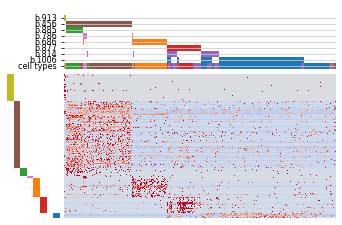

In [27]:
plot_bics = consensus_biclusters.loc[i+new_bic_ids,:].copy()
# downsample to display not more 200 genes 
plot_bics.loc[:,"genes"] = plot_bics.loc[:,"genes"].apply(lambda x: set(sorted(x)[-200:]))
plot_bics.loc[:,"genes_up"] = plot_bics.loc[:,:].apply(lambda x: x["genes_up"].intersection(x["genes"]),axis=1)
plot_bics.loc[:,"genes_down"] =plot_bics.loc[:,:].apply(lambda x: x["genes_down"].intersection(x["genes"]),axis=1)

g = draw_heatmap2(exprs_z,
                    plot_bics, 
                    annot=annot.loc[:,["cell types"]],
                    color_dict=color_dict,
                    color_range=(-3,3),
                    bicluster_colors=color_list+["lightgrey","black","#808080"],
                    figsize = (6,4), 
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.03*4/6,0.03),
                    bic_prefix = "b.",
                    no_cbar=True,
                    col_labels = False,
                    no_row_colors = False,cluster_rows=False
             )
ax = g[0].ax_heatmap
ax.set_xlabel("")#"3kPBMC, n=%s cells"%exprs_z.shape[1]
tmp = ax.set_xlabel(ax.get_xlabel(),fontdict={"size":10})
ax = g[0].ax_row_colors
ax.set_xticks(ticks=[], labels=[])
ax = g[0].ax_col_colors
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":8})
ax.yaxis.tick_left()
#plt.savefig("../../img/Fig6/scanpy_single_cell_Fig6e_v2.png", dpi = 600)
#plt.savefig("../../img/Fig6/scanpy_single_cell_Fig6e_v2.pdf", dpi = 600)

#g[0].ax_row_colors.text(0,-0.1,"e",fontdict={"size":12},
#                        verticalalignment='bottom',
#                       horizontalalignment='left',
#                       transform=g[0].ax_row_colors.transAxes)

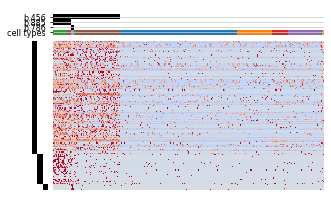

In [28]:
plot_bics = consensus_biclusters.loc[[456,885,786],:].copy() #,1015,1028 # ,877,1015  # 1006,1015,885 # ,1006,999,1020
# downsample to display not more 200 genes 
plot_bics.loc[:,"genes"] = plot_bics.loc[:,"genes"].apply(lambda x: set(sorted(x)[-100:]))
plot_bics.loc[:,"genes_up"] = plot_bics.loc[:,:].apply(lambda x: x["genes_up"].intersection(x["genes"]),axis=1)
plot_bics.loc[:,"genes_down"] =plot_bics.loc[:,:].apply(lambda x: x["genes_down"].intersection(x["genes"]),axis=1)

g = draw_heatmap2(exprs_z,
                    plot_bics, 
                    annot=annot.loc[:,["cell types"]],
                    color_dict=color_dict,
                    color_range=(-3,3),
                    #bicluster_colors=["brown","green","lightgrey","black","#808080"],
                    figsize = (5.5,3.5), 
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.03*3.5/5.5,0.03),
                    bic_prefix = "b.",
                    no_cbar=True,
                    col_labels = False,
                    no_row_colors = False,
                    row_labels= False,
                  cluster_rows=False
             )
ax = g[0].ax_heatmap
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":6})
ax.set_xlabel("")#"3kPBMC, n=%s cells"%exprs_z.shape[1]
tmp = ax.set_xlabel(ax.get_xlabel(),fontdict={"size":10})
ax = g[0].ax_row_colors
ax.set_xticks(ticks=[], labels=[])
ax = g[0].ax_col_colors
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":8})
ax.yaxis.tick_left()

#for ext in ["png","pdf"]:
#    plt.savefig("../../img/Fig6/Fig6_sc_myel_v3."+ext,dpi = 300)



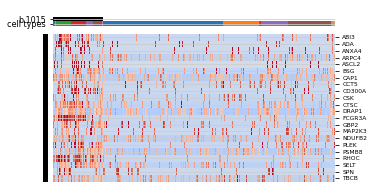

In [29]:
plot_bics = consensus_biclusters.loc[[1015],:].copy() # 456,885,786,877,1015 # 1006,1015,885 # ,1006,999,1020
# downsample to display not more 200 genes 
plot_bics.loc[:,"genes"] = plot_bics.loc[:,"genes"].apply(lambda x: set(sorted(x)[-100:]))
plot_bics.loc[:,"genes_up"] = plot_bics.loc[:,:].apply(lambda x: x["genes_up"].intersection(x["genes"]),axis=1)
plot_bics.loc[:,"genes_down"] =plot_bics.loc[:,:].apply(lambda x: x["genes_down"].intersection(x["genes"]),axis=1)

g = draw_heatmap2(exprs_z,
                    plot_bics, 
                    annot=annot.loc[:,["cell types"]],
                    color_dict=color_dict,
                    color_range=(-3,3),
                    #bicluster_colors=["brown","green","lightgrey","black","#808080"],
                    figsize = (5.5,3.5), 
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.03*3.5/5.5,0.03),
                    bic_prefix = "b.",
                    no_cbar=True,
                    col_labels = False,
                    no_row_colors = False,
                    row_labels= True,
                  cluster_rows=False
             )
ax = g[0].ax_heatmap
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":6})
ax.set_xlabel("")#"3kPBMC, n=%s cells"%exprs_z.shape[1]
tmp = ax.set_xlabel(ax.get_xlabel(),fontdict={"size":10})
ax = g[0].ax_row_colors
ax.set_xticks(ticks=[], labels=[])
ax = g[0].ax_col_colors
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":8})
ax.yaxis.tick_left()

#plt.savefig("../../img/Fig6/scanpy_single_cell_Fig6e_v2.png", dpi = 600)
#plt.savefig("../../img/Fig6/scanpy_single_cell_Fig6e_v2.pdf", dpi = 600)


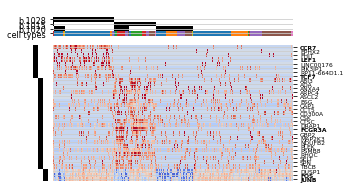

In [30]:
plot_bics = consensus_biclusters.loc[[1028,1015,1020],:].copy() # 456,885,786,877,1015 # 1006,1015,885 # ,1006,999,1020
# downsample to display not more 200 genes 
plot_bics.loc[:,"genes"] = plot_bics.loc[:,"genes"].apply(lambda x: set(sorted(x)[-50:]))
plot_bics.loc[:,"genes_up"] = plot_bics.loc[:,:].apply(lambda x: x["genes_up"].intersection(x["genes"]),axis=1)
plot_bics.loc[:,"genes_down"] =plot_bics.loc[:,:].apply(lambda x: x["genes_down"].intersection(x["genes"]),axis=1)

g = draw_heatmap2(exprs_z,
                    plot_bics, 
                    annot=annot.loc[:,["cell types"]],
                    color_dict=color_dict,
                    color_range=(-3,3),
                    #bicluster_colors=["brown","green","lightgrey","black","#808080"],
                    figsize = (5.5,3.5), 
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.03*3.5/5.5,0.03),
                    bic_prefix = "b.",
                    no_cbar=True,
                    col_labels = False,
                    no_row_colors = False,
                    row_labels= True,
                  cluster_rows=False,
                  highlight_row_labels=["FCGR3A","CCR7","LEF1","TCF7","FOS","JUNB"]
             )
ax = g[0].ax_heatmap
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":6})
ax.set_xlabel("")#"3kPBMC, n=%s cells"%exprs_z.shape[1]
tmp = ax.set_xlabel(ax.get_xlabel(),fontdict={"size":10})
ax = g[0].ax_row_colors
ax.set_xticks(ticks=[], labels=[])
ax = g[0].ax_col_colors
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":8})
ax.yaxis.tick_left()

#for ext in ["png","pdf"]:
#    plt.savefig("../../img/Fig6/Fig6_sc_b_v3."+ext,dpi = 300)

In [31]:
for i in plot_bics.index.values:
    print(i," ".join(sorted(consensus_biclusters.loc[i,"genes"])))

1028 CCR7 EPHX2 FHIT LEF1 LINC00176 PIK3IP1 RP11-664D1.1 TCF7
1015 ABI3 ADA ANXA4 ARPC4 ASCL2 BSG CAP1 CCT5 CD300A CSK CTSC DRAP1 FCGR3A GBP2 MAP2K3 NDUFB2 PLEK PSMB8 RHOC SELT SPN TBCB
1020 DUSP1 FOS JUNB


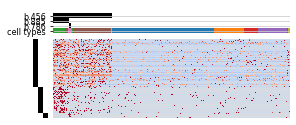

In [35]:
plot_bics = consensus_biclusters.loc[[456,885,786],:].copy() # 456,885,786,877,1015 # 1006,1015,885 # ,1006,999,1020
# downsample to display not more 200 genes 
plot_bics.loc[:,"genes"] = plot_bics.loc[:,"genes"].apply(lambda x: set(sorted(x)[-50:]))
plot_bics.loc[:,"genes_up"] = plot_bics.loc[:,:].apply(lambda x: x["genes_up"].intersection(x["genes"]),axis=1)
plot_bics.loc[:,"genes_down"] =plot_bics.loc[:,:].apply(lambda x: x["genes_down"].intersection(x["genes"]),axis=1)

g = draw_heatmap2(exprs_z,
                    plot_bics, 
                    annot=annot.loc[:,["cell types"]],
                    color_dict=color_dict,
                    color_range=(-3,3),
                    #bicluster_colors=["brown","green","lightgrey","black","#808080"],
                    figsize = (5,2.5), 
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.05*2/5,0.05),
                    bic_prefix = "b.",
                    no_cbar=True,
                    col_labels = False,
                    no_row_colors = False,
                    #row_labels= True,
                  cluster_rows=False
             )
ax = g[0].ax_heatmap
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":6})
ax.set_xlabel("")#"3kPBMC, n=%s cells"%exprs_z.shape[1]
tmp = ax.set_xlabel(ax.get_xlabel(),fontdict={"size":10})
ax = g[0].ax_row_colors
ax.set_xticks(ticks=[], labels=[])
ax = g[0].ax_col_colors
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":8})
ax.yaxis.tick_left()

#plt.savefig("../../img/Fig6/scanpy_single_cell_Fig6e_v2.png", dpi = 600)
#plt.savefig("../../img/Fig6/scanpy_single_cell_Fig6e_v2.pdf", dpi = 600)


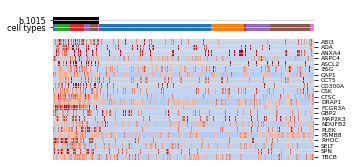

In [38]:
plot_bics = consensus_biclusters.loc[[1015],:].copy() # 456,885,786,877,1015 # 1006,1015,885 # ,1006,999,1020
# downsample to display not more 200 genes 
plot_bics.loc[:,"genes"] = plot_bics.loc[:,"genes"].apply(lambda x: set(sorted(x)[-50:]))
plot_bics.loc[:,"genes_up"] = plot_bics.loc[:,:].apply(lambda x: x["genes_up"].intersection(x["genes"]),axis=1)
plot_bics.loc[:,"genes_down"] =plot_bics.loc[:,:].apply(lambda x: x["genes_down"].intersection(x["genes"]),axis=1)

g = draw_heatmap2(exprs_z,
                    plot_bics, 
                    annot=annot.loc[:,["cell types"]],
                    color_dict=color_dict,
                    color_range=(-3,3),
                    #bicluster_colors=["brown","green","lightgrey","black","#808080"],
                    figsize = (5,2.5), 
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.05*2.5/5,0.05),
                    bic_prefix = "b.",
                    no_cbar=True,
                    col_labels = False,
                    no_row_colors = True,
                    row_labels= True,
                  cluster_rows=False
             )
ax = g[0].ax_heatmap
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":6})
ax.set_xlabel("")#"3kPBMC, n=%s cells"%exprs_z.shape[1]
tmp = ax.set_xlabel(ax.get_xlabel(),fontdict={"size":10})
ax = g[0].ax_row_colors
#ax.set_xticks(ticks=[], labels=[])
ax = g[0].ax_col_colors
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":8})
ax.yaxis.tick_left()

#plt.savefig("../../img/Fig6/scanpy_single_cell_Fig6e_v2.png", dpi = 600)
#plt.savefig("../../img/Fig6/scanpy_single_cell_Fig6e_v2.pdf", dpi = 600)


In [39]:
for i in plot_bics.index.values:
    print(i," ".join(sorted(consensus_biclusters.loc[i,"genes"])))

1015 ABI3 ADA ANXA4 ARPC4 ASCL2 BSG CAP1 CCT5 CD300A CSK CTSC DRAP1 FCGR3A GBP2 MAP2K3 NDUFB2 PLEK PSMB8 RHOC SELT SPN TBCB


In [40]:
# print biomarkers that match biomarkers from the paper
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

d = bm["bm_id"].to_dict()
for ct in d.keys():
    bic_id = d[ct]
    print(bic_id,ct," ".join(sorted(consensus_biclusters.loc[bic_id,"genes"].intersection(set(marker_genes)))))

1006 CD4 T IL7R
456 CD14+ Monocytes CD14 CST3 LGALS3 LYZ MS4A7 S100A8
686 B CD79A MS4A1
877 NK GNLY NKG7
814 CD8 T 
885 FCGR3A+ Monocytes 
786 Dendritic FCER1A
913 Megakaryocytes PPBP


# other biclusters 

In [42]:
b = consensus_biclusters.loc[[i for i in consensus_biclusters.index.values if not i in bm.loc[cell_types,"bm_id"].values],:]
b = b.sort_values("SNR",ascending = False)

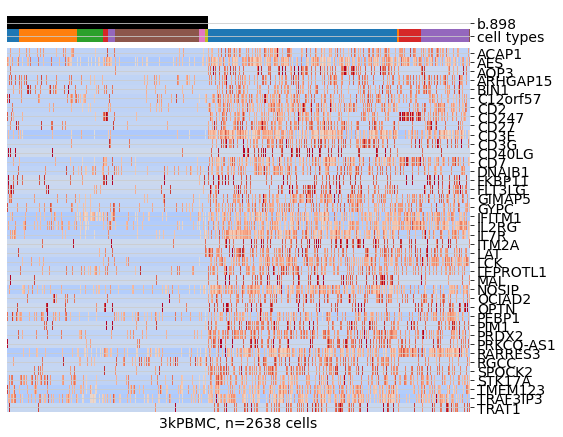

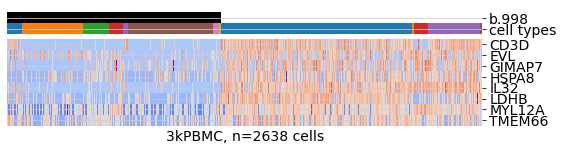

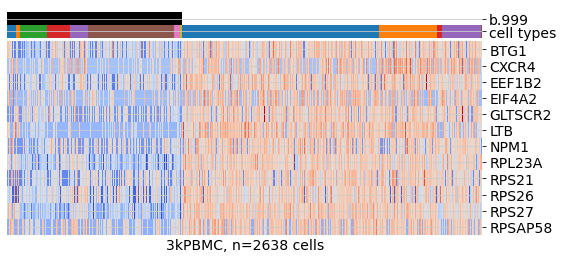

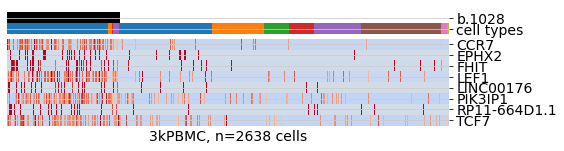

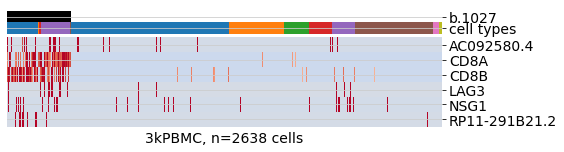

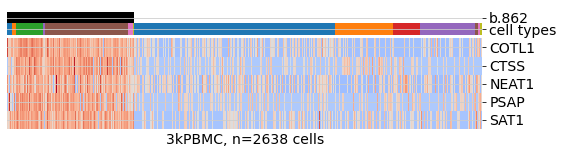

In [43]:
b = consensus_biclusters
for bic_id in [ 898, 998, 999,1028,1027,862]:
    i = [bic_id]
    fig_h = 6
    if b.loc[bic_id,"n_genes"]<20:
        fig_h = 3.5
    if b.loc[bic_id,"n_genes"]<10:
        fig_h = 2
    g = draw_heatmap2(exprs_z,
                        consensus_biclusters.loc[i,:], 
                        annot=annot.loc[:,["cell types"]],
                        color_dict=color_dict,
                        #bicluster_colors=color_list,
                        figsize = (8,fig_h), 
                        dendrogram_ratio=(0.01,0.01),
                        colors_ratio=(0.03,0.2/fig_h),
                        bic_prefix = "b.",
                        no_cbar=True,
                        col_labels = False,
                        row_labels = True,
                        no_row_colors = True,
                        cluster_rows=False
                 )
    ax = g[0].ax_heatmap
    ax.set_xlabel("3kPBMC, n=%s cells"%exprs_z.shape[1])
    #tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":7})

Text(-0.45, -0.05, 'a')

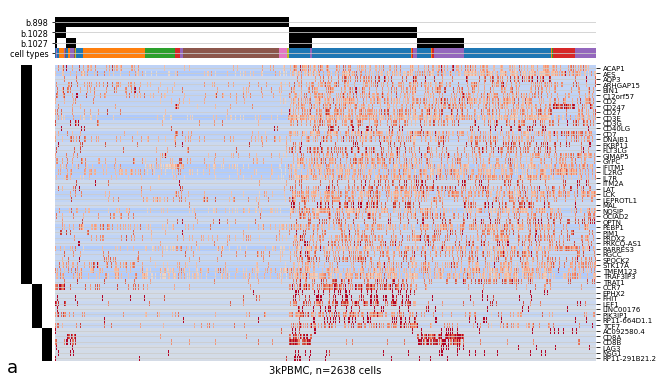

In [44]:
i = [898,1028,1027]  

g = draw_heatmap2(exprs_z,
                    consensus_biclusters.loc[i,:], 
                    annot=annot.loc[:,["cell types"]],
                    color_dict=color_dict,
                    #bicluster_colors=color_list,
                    figsize = (10,6), 
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.03/10*6,0.03),
                    bic_prefix = "b.",
                    no_cbar=True,
                    col_labels = False,
                    row_labels = True,
                    no_row_colors = False,
                    cluster_rows=False
             )
ax = g[0].ax_heatmap
ax.set_xlabel("3kPBMC, n=%s cells"%exprs_z.shape[1])
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":7})
tmp = ax.set_xlabel(ax.get_xlabel(),fontdict={"size":10})
ax = g[0].ax_row_colors
ax.set_xticks(ticks=[], labels=[])
ax = g[0].ax_col_colors
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":8})
ax.yaxis.tick_left()
g[0].ax_row_colors.text(-0.45,-0.05,"a",fontdict={"size":18},
                        verticalalignment='bottom',
                       horizontalalignment='left',
                       transform=g[0].ax_row_colors.transAxes)


#plt.savefig("../../img/Figs_suppl/single_cell_scanpy/scanpy_Tcells_a.png", dpi = 300)
#plt.savefig("../../img/Figs_suppl/single_cell_scanpy/scanpy_Tcells_a.pdf", dpi = 600)
#plt.savefig("../../img/Figs_suppl/single_cell_scanpy/scanpy_Tcells_a.svg")


Text(-150, 5.5, 'b')

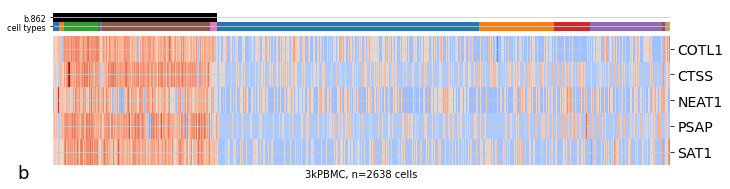

In [45]:
i =  [862] # myeloid

g = draw_heatmap2(exprs_z,
                    consensus_biclusters.loc[i,:], 
                    annot=annot.loc[:,["cell types"]],
                    color_dict=color_dict,
                    #bicluster_colors=color_list,
                    figsize = (10,2.5), 
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.06/10*2,0.06),
                    bic_prefix = "b.",
                    no_cbar=True,
                    col_labels = False,
                    row_labels = True,
                    no_row_colors = True,
                    cluster_rows=False
             )

ax = g[0].ax_heatmap
ax.set_xlabel("3kPBMC, n=%s cells"%exprs_z.shape[1])
#tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":7})
tmp = ax.set_xlabel(ax.get_xlabel(),fontdict={"size":10})
ax = g[0].ax_row_colors
#ax.set_xticks(ticks=[], labels=[])
ax = g[0].ax_col_colors
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":8})
ax.yaxis.tick_left()

"""g[0].ax_heatmap.text(0.08,0.1,"b",fontdict={"size":18},
                       #verticalalignment='bottom',
                       #horizontalalignment='left',
                       transform=g[0].ax_heatmap.transAxes
                    )"""
g[0].ax_heatmap.text(-150,5.5,"b",fontdict={"size":18})
#plt.savefig("../../img/Figs_suppl/single_cell_scanpy/scanpy_Myeloid_b.png",dpi = 300)
#plt.savefig("../../img/Figs_suppl/single_cell_scanpy/scanpy_Myeloid_b.pdf",dpi = 600)
#plt.savefig("../../img/Figs_suppl/single_cell_scanpy/scanpy_Myeloid_b.svg")

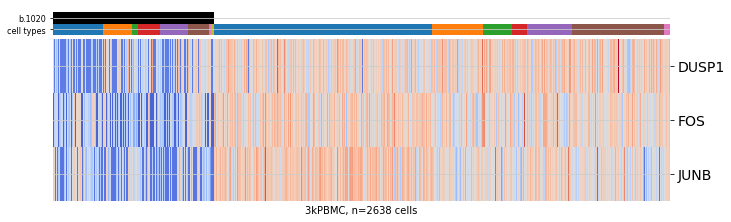

In [48]:
i = [1020] #

g = draw_heatmap2(exprs_z,
                    consensus_biclusters.loc[i,:], 
                    annot=annot.loc[:,["cell types"]],
                    color_dict=color_dict,
                    #bicluster_colors=color_list,
                    figsize = (10,3), 
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.06/10*3,0.06),
                    bic_prefix = "b.",
                    no_cbar=True,
                    col_labels = False,
                    row_labels = True,
                    no_row_colors = True,
                    cluster_rows=False
             )
ax = g[0].ax_heatmap
ax.set_xlabel("3kPBMC, n=%s cells"%exprs_z.shape[1])
tmp = ax.set_xlabel(ax.get_xlabel(),fontdict={"size":10})
ax = g[0].ax_row_colors
ax = g[0].ax_col_colors
tmp = ax.set_yticklabels(ax.get_yticklabels(),fontdict={"size":8})
ax.yaxis.tick_left()
#plt.savefig("../../img/Figs_suppl/single_cell_scanpy/scanpy_other_c.png", dpi = 300)
#plt.savefig("../../img/Figs_suppl/single_cell_scanpy/scanpy_other_c.pdf", dpi = 600)
#plt.savefig("../../img/Figs_suppl/single_cell_scanpy/scanpy_other_c.svg")